In [1]:
from google.colab import drive, auth
import sys
import numpy as np
import pandas as pd
import tensorflow_hub as hub
import librosa
import matplotlib.pyplot as plt
import csv
from IPython.display import Audio

#sklearn libraries
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

#tensorflow for modles
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout, LSTM, Conv2D, MaxPooling2D, Flatten, concatenate, Reshape, BatchNormalization
import tensorflow_hub as hub
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import Callback,EarlyStopping
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from keras import metrics
tf.get_logger().setLevel('INFO')

#mount drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
#declare sampling rate
sampling_rate = 16000
#get the audio path of all the audios
audio_path = '/content/drive/MyDrive/UCB-MIDS/SEM-2/MACHINE-LEARNING-207/207-Project/data/train/librosa_loaded/'

In [10]:
#Read the data and get the shapes of the dataframe
bird_df = pd.read_csv('/content/drive/MyDrive/UCB-MIDS/SEM-2/MACHINE-LEARNING-207/207-Project/notebooks/RG/3_species/train_val.csv')

#lets only keep audio files > 8 sec
bird_df = bird_df[bird_df['duration_secs_32000'] >= 8]
print(bird_df.shape)

bird_df.head(2)

(794, 9)


,primary_label,filename,type,filename_npy,rating,duration_secs_32000,country,continent,data
0,eaywag1,eaywag1/XC718442.ogg,blank,eaywag1/XC718442.npy,good,12.538781,FR,EUROPE,train
1,eaywag1,eaywag1/XC675682.ogg,call,eaywag1/XC675682.npy,good,35.657000,RU,EUROPE,train


In [11]:
continent_varieties = bird_df['continent'].value_counts()
print(continent_varieties)

EUROPE      671
ASIA         59
AMERICAS     38
UNKNOWN      15
AFRICA       11
Name: continent, dtype: int64


In [12]:
# Assuming you have your dataframe loaded into the variable "df"
bird_df = pd.get_dummies(bird_df, columns=['continent'], prefix='continent')
bird_df.head(2)

,primary_label,filename,type,filename_npy,rating,duration_secs_32000,country,data,continent_AFRICA,continent_AMERICAS,continent_ASIA,continent_EUROPE,continent_UNKNOWN
0,eaywag1,eaywag1/XC718442.ogg,blank,eaywag1/XC718442.npy,good,12.538781,FR,train,0,0,0,1,0
1,eaywag1,eaywag1/XC675682.ogg,call,eaywag1/XC675682.npy,good,35.657000,RU,train,0,0,0,1,0


In [13]:
#Gather the training data from the main dataset
bird_train_df = bird_df[bird_df['data'] == 'train']
print("train data:",bird_train_df.shape)

#Gather the separate validation set from the csv
bird_val_df =  bird_df[bird_df['data'] == 'val']
print("validation data:",bird_val_df.shape)

train data: (560, 13)
validation data: (234, 13)


In [14]:
bird_train_df.head(1)

,primary_label,filename,type,filename_npy,rating,duration_secs_32000,country,data,continent_AFRICA,continent_AMERICAS,continent_ASIA,continent_EUROPE,continent_UNKNOWN
0,eaywag1,eaywag1/XC718442.ogg,blank,eaywag1/XC718442.npy,good,12.538781,FR,train,0,0,0,1,0


In [15]:
#Function to load the audio
def load_audio(file_name):
    audio = np.load(audio_path + file_name)
    return audio

In [16]:
#chunk the audio into 5 sec frame with no overlaps
def frame_audio(
      audio_array: np.ndarray,
      window_size_s: float = 8.0,
      hop_size_s: float = 4.0,
      sample_rate = sampling_rate,
      ) -> np.ndarray:

    """Helper function for framing audio for inference."""
    """ using tf.signal """
    if window_size_s is None or window_size_s < 0:
        return audio_array[np.newaxis, :]
    frame_length = int(window_size_s * sample_rate)
    hop_length = int(hop_size_s * sample_rate)
    framed_audio = tf.signal.frame(audio_array, frame_length, hop_length, pad_end=False)
    return framed_audio

In [56]:
def extract_mfcc_chroma_and_continent_from_frames(framed_audio, class_label, continent_feature, sample_rate=16000, n_mfcc=20, n_chroma=12):
    mfcc_frames = []
    chroma_frames = []
    continent_frames = []
    target_label = []

    for frame in framed_audio:
        frame = np.array(frame)

        # Extract MFCC from the main audio frame
        mfcc = librosa.feature.mfcc(y=frame, sr=sample_rate, n_mfcc=n_mfcc)
        transposed_mfcc = mfcc.T

        # Extract chroma from the main audio frame
        chroma = librosa.feature.chroma_stft(y=frame, sr=sample_rate, n_chroma=n_chroma)
        transposed_chroma = chroma.T

        # Check if the number of frames is the same for MFCC and chroma features
        min_frames = min(len(transposed_mfcc), len(transposed_chroma))

        # Repeat the continent feature to match the number of frames
        continent_feature_repeat = np.repeat(np.array([continent_feature]), min_frames, axis=0)

        # Append the features to the respective lists
        mfcc_frames.append(transposed_mfcc[:min_frames])
        chroma_frames.append(transposed_chroma[:min_frames])
        continent_frames.extend([continent_feature_repeat] * min_frames)
        target_label.append(class_label)

    # Combine MFCC, chroma, and continent features along the time axis
    combined_frames = [np.hstack((mfcc, chroma, continent)) for mfcc, chroma, continent in zip(mfcc_frames, chroma_frames, continent_frames)]
    combined_frames = np.array(combined_frames)

    return combined_frames, target_label



In [57]:
def extract_final_features_from_dataframe(df):
    features = []
    target_labels = []
    continents = []

    for index, row in df.iterrows():
        file_name = str(row['filename_npy'])
        class_label = row["primary_label"]
        continent_feature = row[["continent_AFRICA", "continent_AMERICAS", "continent_ASIA", "continent_EUROPE", "continent_UNKNOWN"]]  # Extract the continent feature from the dataframe

        # For audios with duration >= 8 seconds, proceed as before
        audio = load_audio(file_name)  # Load the audio using the load_audio function
        framed_audio = frame_audio(audio)  # Frame the audio into 8-second segments

        # Extract MFCC, chroma, and continent features for each frame
        feature_frames, target_label = extract_mfcc_chroma_and_continent_from_frames(framed_audio, class_label, continent_feature, sample_rate=sampling_rate)

        features.extend(feature_frames)
        target_labels.extend(target_label)

    return features, target_labels


In [58]:
#encode the target variable
def encode_labels(y_train, y_val):
    # Perform one-hot encoding on y_train
    le = LabelEncoder()
    encoded_y_train = to_categorical(le.fit_transform(y_train))

    # Perform one-hot encoding on y_val
    le = LabelEncoder()
    encoded_y_val = to_categorical(le.fit_transform(y_val))

    return encoded_y_train, encoded_y_val

In [51]:
#scale data
def scale_data(data):
    # Reshape the data to 2D array
    num_samples, num_time_steps, num_features = data.shape
    data_reshaped = data.reshape(num_samples, num_features * num_time_steps)

    # Create the MinMaxScaler object and fit it to the data
    scaler = MinMaxScaler(feature_range=(0, 1))
    data_scaled = scaler.fit_transform(data_reshaped)

    # Reshape the scaled data back to its original shape
    data_scaled = data_scaled.reshape(num_samples, num_time_steps, num_features)

    return data_scaled

In [52]:
#create a function to shuffle the data
def shuffle_data(x, y, random_state=1234):
    num_samples = x.shape[0]
    random_indices = np.random.RandomState(random_state).permutation(num_samples)
    x_shuffled = x[random_indices]
    y_shuffled = y[random_indices]
    return x_shuffled, y_shuffled

In [59]:
# Extract the mfcc embeddings from the model
train_embeddings, labels = extract_final_features_from_dataframe(bird_train_df)

/usr/local/lib/python3.10/dist-packages/librosa/core/pitch.py:102: UserWarning: Trying to estimate tuning from empty frequency set.
  return pitch_tuning(
/usr/local/lib/python3.10/dist-packages/librosa/core/pitch.py:102: UserWarning: Trying to estimate tuning from empty frequency set.
  return pitch_tuning(
/usr/local/lib/python3.10/dist-packages/librosa/core/pitch.py:102: UserWarning: Trying to estimate tuning from empty frequency set.
  return pitch_tuning(
/usr/local/lib/python3.10/dist-packages/librosa/core/pitch.py:102: UserWarning: Trying to estimate tuning from empty frequency set.
  return pitch_tuning(
/usr/local/lib/python3.10/dist-packages/librosa/core/pitch.py:102: UserWarning: Trying to estimate tuning from empty frequency set.
  return pitch_tuning(
/usr/local/lib/python3.10/dist-packages/librosa/core/pitch.py:102: UserWarning: Trying to estimate tuning from empty frequency set.
  return pitch_tuning(
/usr/local/lib/python3.10/dist-packages/librosa/core/pitch.py:102: Use

In [60]:
train_embeddings[:1]

[array([[-640.85791015625, 64.67718505859375, -62.98855209350586, ..., 0,
         1, 0],
        [-367.0238037109375, 61.16319274902344, -64.07255554199219, ...,
         0, 1, 0],
        [-292.5032043457031, 58.88468933105469, -67.40597534179688, ...,
         0, 1, 0],
        ...,
        [-291.0174560546875, 61.561676025390625, -57.485897064208984, ...,
         0, 1, 0],
        [-291.3058776855469, 53.77311706542969, -54.28373336791992, ...,
         0, 1, 0],
        [-329.6281433105469, 48.12044906616211, -49.138999938964844, ...,
         0, 1, 0]], dtype=object)]

In [61]:
#verify the shapes
x_train = np.array(train_embeddings)
y_train = np.array(labels)
print(x_train.shape)
print(y_train.shape)

(4555, 251, 37)
(4555,)


In [62]:
#extract the embeddings
val_embeddings, val_labels = extract_final_features_from_dataframe(bird_val_df)

/usr/local/lib/python3.10/dist-packages/librosa/core/pitch.py:102: UserWarning: Trying to estimate tuning from empty frequency set.
  return pitch_tuning(
/usr/local/lib/python3.10/dist-packages/librosa/core/pitch.py:102: UserWarning: Trying to estimate tuning from empty frequency set.
  return pitch_tuning(
/usr/local/lib/python3.10/dist-packages/librosa/core/pitch.py:102: UserWarning: Trying to estimate tuning from empty frequency set.
  return pitch_tuning(
/usr/local/lib/python3.10/dist-packages/librosa/core/pitch.py:102: UserWarning: Trying to estimate tuning from empty frequency set.
  return pitch_tuning(
/usr/local/lib/python3.10/dist-packages/librosa/core/pitch.py:102: UserWarning: Trying to estimate tuning from empty frequency set.
  return pitch_tuning(
/usr/local/lib/python3.10/dist-packages/librosa/core/pitch.py:102: UserWarning: Trying to estimate tuning from empty frequency set.
  return pitch_tuning(
/usr/local/lib/python3.10/dist-packages/librosa/core/pitch.py:102: Use

In [63]:
#display a sample embedding from the validation dataset
val_embeddings[:1]

[array([[-340.6138000488281, 127.00826263427734, 44.27177429199219, ...,
         1, 0, 0],
        [-283.61669921875, 124.63981628417969, 38.063232421875, ..., 1, 0,
         0],
        [-275.97564697265625, 124.30683135986328, 34.929054260253906, ...,
         1, 0, 0],
        ...,
        [-273.9812316894531, 136.26806640625, 51.75334167480469, ..., 1,
         0, 0],
        [-267.3425598144531, 130.7334442138672, 47.94989776611328, ..., 1,
         0, 0],
        [-283.4364013671875, 116.29226684570312, 34.94989776611328, ...,
         1, 0, 0]], dtype=object)]

In [64]:
#verify the val data shapes
x_val = np.array(val_embeddings)
y_val = np.array(val_labels)
print(x_val.shape)
print(y_val.shape)

(1785, 251, 37)
(1785,)


In [65]:
#call the function to encode y
y_train_encoded, y_val_encoded = encode_labels(y_train, y_val)
#verify the shape
print(y_train_encoded.shape)
print(y_val_encoded.shape)

(4555, 3)
(1785, 3)


In [66]:
#scale the extracted embeddings
x_train_scaled = scale_data(x_train)
x_val_scaled = scale_data(x_val)
print(x_train_scaled[:1])

[[[0.33978738 0.68793538 0.28209973 ... 0.         1.         0.        ]
  [0.59280273 0.66793327 0.28650357 ... 0.         1.         0.        ]
  [0.67914246 0.64029561 0.33524839 ... 0.         1.         0.        ]
  ...
  [0.64161968 0.68365215 0.38953686 ... 0.         1.         0.        ]
  [0.65400476 0.6328816  0.38573987 ... 0.         1.         0.        ]
  [0.65841814 0.62336723 0.39894912 ... 0.         1.         0.        ]]]


In [67]:
#shuffle both train and validation sets
x_shuffled_train, y_shuffled_train = shuffle_data(x_train_scaled, y_train_encoded)
x_shuffled_val, y_shuffled_val = shuffle_data(x_val_scaled, y_val_encoded)

print(x_shuffled_train.shape)
print(y_shuffled_train.shape)

print(x_shuffled_val.shape)
print(y_shuffled_val.shape)

(4555, 251, 37)
(4555, 3)
(1785, 251, 37)
(1785, 3)


In [68]:
def create_1d_cnn_model(input_shape, n_classes, learning_rate=0.002):
    model = tf.keras.Sequential()

    # Add first 1D convolution layer to the model
    model.add(tf.keras.layers.Conv1D(
        filters=32,
        kernel_size=5,
        strides=1,
        padding='same',
        input_shape=input_shape,
        activation='relu',
        kernel_regularizer=tf.keras.regularizers.l2(0.01)
    ))

    # Add max pooling layer with pool size 2 and strides 2 (reduces spatial dimensions by half)
    model.add(tf.keras.layers.MaxPool1D(
        pool_size=2
    ))

    # Add second 1D convolutional layer
    model.add(tf.keras.layers.Conv1D(
        filters=64,
        kernel_size=5,
        strides=1,
        padding='same',
        activation='relu',
        kernel_regularizer=tf.keras.regularizers.l2(0.01)
    ))

    # Add second max pooling layer with pool size 2 and strides 2 (further reduces spatial dimensions by half)
    model.add(tf.keras.layers.MaxPool1D(
        pool_size=2
    ))

    # Flatten the output of the previous layers before fully connected layers
    model.add(tf.keras.layers.Flatten())

    # Add a fully connected layer with 1024 units and ReLU activation
    model.add(tf.keras.layers.Dense(
        units=1024,
        activation='relu'
    ))

    # Add dropout layer to prevent overfitting
    model.add(tf.keras.layers.Dropout(rate=0.4))

    # Add the last fully connected layer with n_classes units and no activation function (logits)
    model.add(tf.keras.layers.Dense(
        units=n_classes,
        activation=None
    ))

    # Compile the model
    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    model.compile(loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
                  optimizer=optimizer,
                  metrics=['accuracy'])

    return model

In [69]:
# Function to train the 1D CNN model
def train_cnn_model(x_shuffled_train, y_shuffled_train, x_shuffled_val, y_shuffled_val,
                     learning_rate=0.002, batch_size=32, n_classes=3, epochs=100):
    input_shape = x_shuffled_train.shape[1:]

    model = create_1d_cnn_model(input_shape, n_classes, learning_rate)

    model.summary()

    # Define the early stopping callback
    earlystop = EarlyStopping(monitor='val_loss', patience=10, verbose=1, restore_best_weights=True)

    # Train the model
    history = model.fit(x_shuffled_train, y_shuffled_train, validation_data=(x_shuffled_val, y_shuffled_val),
                        batch_size=batch_size, callbacks=[earlystop], epochs=epochs)

    return model, history

In [70]:
model, history = train_cnn_model(x_shuffled_train, y_shuffled_train, x_shuffled_val, y_shuffled_val,
                                 learning_rate=0.002, batch_size=32, n_classes=3, epochs=100)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 251, 32)           5952      
                                                                 
 max_pooling1d (MaxPooling1D  (None, 125, 32)          0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 125, 64)           10304     
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 62, 64)           0         
 1D)                                                             
                                                                 
 flatten (Flatten)           (None, 3968)              0         
                                                                 
 dense (Dense)               (None, 1024)              4

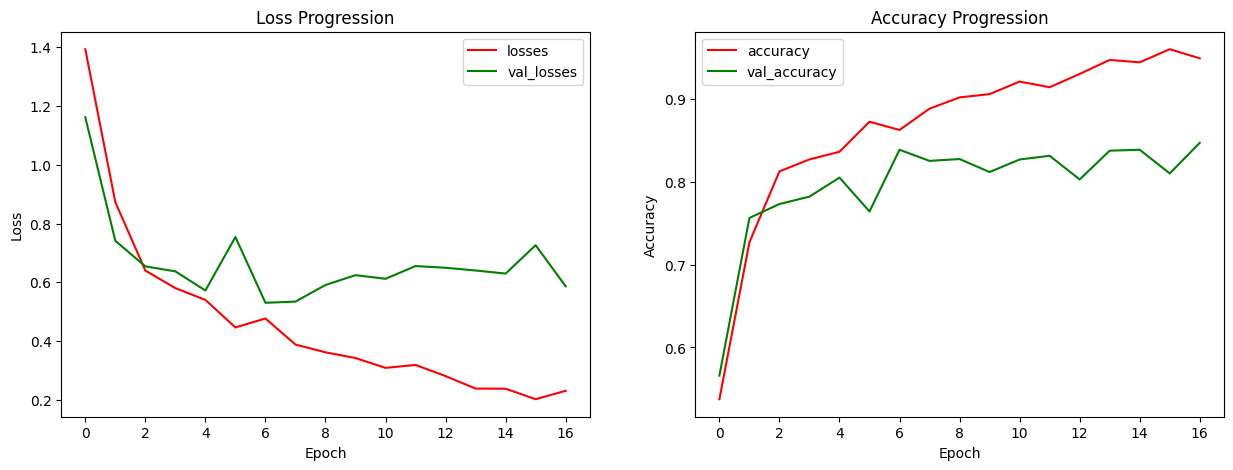

In [71]:
import matplotlib.pyplot as plt

def plot_accuracy(history):
    # Plot the training and validation accuracy and losses
    num_epochs = len(history.history['loss'])
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

    axes[0].plot(range(num_epochs), history.history['loss'], color='red', label='losses')
    axes[0].plot(range(num_epochs), history.history['val_loss'], color='green', label='val_losses')
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('Loss')
    axes[0].set_title('Loss Progression')
    axes[0].legend()

    axes[1].plot(range(num_epochs), history.history['accuracy'], color='red', label='accuracy')
    axes[1].plot(range(num_epochs), history.history['val_accuracy'], color='green', label='val_accuracy')
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('Accuracy')
    axes[1].set_title('Accuracy Progression')
    axes[1].legend()
    plt.show()

#call the plot function
plot_accuracy(history)

In [72]:
# The result of model.predict has an extra dimension, so we flatten to get a
# vector of predictions.
test_pred_train = np.argmax(history.model.predict(x_shuffled_train), axis=-1)
test_pred = np.argmax(history.model.predict(x_shuffled_val), axis=-1)
print(test_pred_train)
print(test_pred)

56/56 [==============================] - 1s 16ms/step
[2 2 0 ... 2 2 1]
[0 1 1 ... 0 1 1]


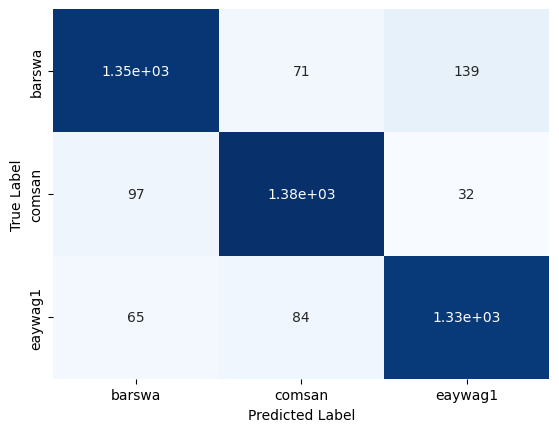

              precision    recall  f1-score   support

           0      0.893     0.865     0.879      1561
           1      0.899     0.915     0.907      1513
           2      0.886     0.899     0.893      1481

    accuracy                          0.893      4555
   macro avg      0.893     0.893     0.893      4555
weighted avg      0.893     0.893     0.893      4555



In [73]:
#plot the  confusion matrix on the train dataset
class_label = ['barswa',  'comsan',  'eaywag1']

# Create a confusion matrix as a 2D array.
from sklearn import metrics

y_train_1d = np.argmax(y_shuffled_train, axis=1)
confusion_matrix = tf.math.confusion_matrix(y_train_1d, test_pred_train)

# Use a heatmap plot to display it.
ax = sns.heatmap(confusion_matrix, annot=True, fmt='.3g', cmap='Blues',
                 xticklabels=class_label, yticklabels=class_label, cbar=False)

# Add axis labels.
ax.set(xlabel='Predicted Label', ylabel='True Label')
plt.show()

#Print the precision, recall and F1-score using metrics from sklearn
print(metrics.classification_report(y_train_1d, test_pred_train, digits=3, zero_division='warn'))

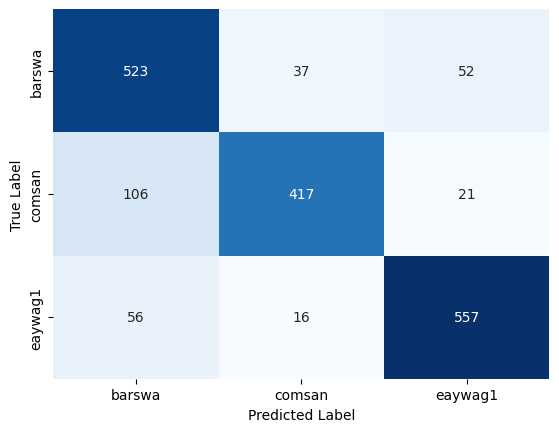

              precision    recall  f1-score   support

           0      0.764     0.855     0.806       612
           1      0.887     0.767     0.822       544
           2      0.884     0.886     0.885       629

    accuracy                          0.839      1785
   macro avg      0.845     0.836     0.838      1785
weighted avg      0.844     0.839     0.839      1785



In [74]:
#plot the confusion matrix on the test dataset
class_label = ['barswa',  'comsan',  'eaywag1']

# Create a confusion matrix as a 2D array.
from sklearn import metrics

y_val_1d = np.argmax(y_shuffled_val, axis=1)
confusion_matrix = tf.math.confusion_matrix(y_val_1d, test_pred)

# Use a heatmap plot to display it.
ax = sns.heatmap(confusion_matrix, annot=True, fmt='.3g', cmap='Blues',
                 xticklabels=class_label, yticklabels=class_label, cbar=False)

# Add axis labels.
ax.set(xlabel='Predicted Label', ylabel='True Label')
plt.show()

#Print the precision, recall and F1-score using metrics from sklearn
print(metrics.classification_report(y_val_1d, test_pred, digits=3, zero_division='warn'))

In [76]:
model.save('/content/drive/MyDrive/UCB-MIDS/SEM-2/MACHINE-LEARNING-207/207-Project/notebooks/HS/CNN/1b.1dcnn.model.h5')